## Task 1: Facial Emotion Detection

model.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir(r'/content/drive/MyDrive')

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchsummary
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import csv
import os.path as osp

import cv2
import matplotlib.cm as cm
import torch.hub
import os
from torchvision import transforms
from torchsummary import summary

In [4]:
class SeparableConv2d(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
    super(SeparableConv2d, self).__init__()
    self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                               bias=bias)
    self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x


class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()

    self.residual_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2,
                                  bias=False)
    self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

    self.sepConv1 = SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                    padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
    self.relu = nn.ReLU()

    self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                    padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
    self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

  def forward(self, x):
    res = self.residual_conv(x)
    res = self.residual_bn(res)
    x = self.sepConv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.sepConv2(x)
    x = self.bn2(x)
    x = self.maxp(x)
    return res + x

### 1.

In [5]:
class Model(nn.Module):

  def __init__(self, num_classes):
    super(Model, self).__init__()
    # use for Xception model
    ####### ENTER YOUR CODE HERE #######
    self.conv2d_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1)
    self.bn1 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
    self.relu1 = nn.ReLU()

    self.conv2d_2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1)
    self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
    self.relu2 = nn.ReLU()

    self.rb1 = ResidualBlock(in_channels=8, out_channels=16)
    self.rb2 = ResidualBlock(in_channels=16, out_channels=32)
    self.rb3 = ResidualBlock(in_channels=32, out_channels=64)
    self.rb4 = ResidualBlock(in_channels=64, out_channels=128)

    self.conv2d_3 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1, stride=1)

    self.adAvPool = nn.AdaptiveAvgPool2d((1,1))
    ####################################

  def forward(self, input):
    # use for Xception model
    ####### ENTER YOUR CODE HERE #######
    x = self.conv2d_1(input)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2d_2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.rb1(x)
    x = self.rb2(x)
    x = self.rb3(x)
    x = self.rb4(x)
    
    x = self.conv2d_3(x)
    x = self.adAvPool(x)
    x = torch.squeeze(x) # (128,7)
    
    return x

train.py

In [6]:
start_time = time.time()

if not torch.cuda.is_available():
  from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

shape = (44, 44)


class DataSetFactory:

  def __init__(self):
    images = []
    emotions = []
    private_images = []
    private_emotions = []
    public_images = []
    public_emotions = []

    # with open('../dataset/fer2013.csv', 'r') as csvin:
    with open('fer2013.csv', 'r') as csvin:
      data = csv.reader(csvin)
      next(data)
      for row in data:
        face = [int(pixel) for pixel in row[1].split()]
        face = np.asarray(face).reshape(48, 48)
        face = face.astype('uint8')

        if row[-1] == 'Training':
          emotions.append(int(row[0]))
          images.append(Image.fromarray(face))
        elif row[-1] == "PrivateTest":
          private_emotions.append(int(row[0]))
          private_images.append(Image.fromarray(face))
        elif row[-1] == "PublicTest":
          public_emotions.append(int(row[0]))
          public_images.append(Image.fromarray(face))

    print('training size %d : private val size %d : public val size %d' % (
        len(images), len(private_images), len(public_images)))
    train_transform = transforms.Compose([
        transforms.RandomCrop(shape[0]),
        transforms.RandomHorizontalFlip(),
        ToTensor(),
    ])
    val_transform = transforms.Compose([
        transforms.CenterCrop(shape[0]),
        ToTensor(),
    ])

    self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
    self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
    self.public = DataSet(transform=val_transform, images=public_images, emotions=public_emotions)

### 2.

In [28]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, transform=None, images=None, emotions=None):
    self.transform = transform
    self.images = images
    self.emotions = emotions

  def __getitem__(self, index):
    image = self.images[index]
    emotion = self.emotions[index]
    if self.transform is not None:
      image = self.transform(image)
    return image, emotion

  def __len__(self):
    return len(self.images)


def plot_loss(losses, name):
  # use for loss plot
  ####### ENTER YOUR CODE HERE #######
  plt.figure()
  t = np.arange(len(losses))
  plt.plot(t, losses, color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(name+' loss')

def plot_acc(accs, name):
  # use for acc plot
  ####### ENTER YOUR CODE HERE #######
  plt.figure()
  t = np.arange(len(accs))
  plt.plot(t, accs, color='green')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(name+' accuracy')

In [8]:
def main():
  # variables  -------------
  batch_size = 128
  lr = 0.01
  epochs = 20
  learning_rate_decay_start = 80
  learning_rate_decay_every = 5
  learning_rate_decay_rate = 0.9
  # Add variables
  train_losses = []
  train_accs = []

  p_test_losses = []
  p_test_accs = []
  # ------------------------

  classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  # network = model.Model(num_classes=len(classes)).to(device)
  network = Model(num_classes=len(classes)).to(device)
  if not torch.cuda.is_available():
    summary(network, (1, shape[0], shape[1]))

  optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=5e-3)
  criterion = nn.CrossEntropyLoss()
  factory = DataSetFactory()

  training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=1)
  validation_loader = {
    'private': DataLoader(factory.private, batch_size=batch_size, shuffle=True, num_workers=1),
    'public': DataLoader(factory.public, batch_size=batch_size, shuffle=True, num_workers=1)
  }

  min_validation_loss = {
    'private': 10000,
    'public': 10000,
  }

  for epoch in tqdm(range(epochs)):
    network.train()
    total = 0
    correct = 0
    total_train_loss = 0
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
      frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
      decay_factor = learning_rate_decay_rate ** frac
      current_lr = lr * decay_factor
      for group in optimizer.param_groups:
        group['lr'] = current_lr
    else:
      current_lr = lr

    print('learning_rate: %s' % str(current_lr))
    for i, (x_train, y_train) in enumerate(training_loader):
      optimizer.zero_grad()
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      y_predicted = network(x_train)
      loss = criterion(y_predicted, y_train)
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(y_predicted.data, 1)
      total_train_loss += loss.data
      total += y_train.size(0)
      correct += predicted.eq(y_train.data).sum()
    accuracy = 100. * float(correct) / total
    print('Epoch [%d/%d] Training Loss: %.4f, Accuracy: %.4f' % (
      epoch + 1, epochs, total_train_loss / (i + 1), accuracy))
    
    # Record train loss
    train_losses.append(total_train_loss / (i + 1))
    # Record train acc
    train_accs.append(accuracy)
    

    network.eval()
    with torch.no_grad():
      # Added 
      total_p = 0
      correct_p = 0
      total_validation_loss_p = 0
      p_count = 0
      accuracy_p = 0
      for name in ['private', 'public']:
        total = 0
        correct = 0
        total_validation_loss = 0
        
        for j, (x_val, y_val) in enumerate(validation_loader[name]):
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          y_val_predicted = network(x_val)
          val_loss = criterion(y_val_predicted, y_val)
          _, predicted = torch.max(y_val_predicted.data, 1)
          total_validation_loss += val_loss.data
          # Only record private
          if name == 'private':
            total_validation_loss_p += val_loss.data
            p_count += 1
            total_p += y_val.size(0)
            correct_p += predicted.eq(y_val.data).sum()

          total += y_val.size(0)
          correct += predicted.eq(y_val.data).sum()

        accuracy = 100. * float(correct) / total
        if name =='private':
          accuracy_p = 100. * float(correct_p) / total_p
        
        if total_validation_loss <= min_validation_loss[name]:
          if epoch >= 10:
            print('saving new model')
            state = {'net': network.state_dict()}
            # torch.save(state, '../trained/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
            torch.save(state, 'trained/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
          min_validation_loss[name] = total_validation_loss

        print('Epoch [%d/%d] %s validation Loss: %.4f, Accuracy: %.4f' % (
          epoch + 1, epochs, name, total_validation_loss / (j + 1), accuracy))
        
        # Record private test loss
        if name == 'private':
          p_test_losses.append(total_validation_loss_p / p_count)
          p_test_accs.append(accuracy_p)

  return train_losses, train_accs, p_test_losses, p_test_accs

In [15]:
train_losses, train_accs, p_test_losses, p_test_accs = main()
print('Time Taken- ', str(time.time()-start_time), ' seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

training size 28709 : private val size 3589 : public val size 3589
learning_rate: 0.01
Epoch [1/20] Training Loss: 1.7270, Accuracy: 31.8785
Epoch [1/20] private validation Loss: 1.5708, Accuracy: 38.3115


  5%|▌         | 1/20 [00:05<01:49,  5.77s/it]

Epoch [1/20] public validation Loss: 1.5745, Accuracy: 38.1165
learning_rate: 0.01
Epoch [2/20] Training Loss: 1.4656, Accuracy: 43.5578
Epoch [2/20] private validation Loss: 1.5067, Accuracy: 43.1318


 10%|█         | 2/20 [00:11<01:44,  5.81s/it]

Epoch [2/20] public validation Loss: 1.5030, Accuracy: 43.1875
learning_rate: 0.01
Epoch [3/20] Training Loss: 1.3504, Accuracy: 48.4099
Epoch [3/20] private validation Loss: 1.3263, Accuracy: 50.0975


 15%|█▌        | 3/20 [00:17<01:40,  5.92s/it]

Epoch [3/20] public validation Loss: 1.3163, Accuracy: 49.5124
learning_rate: 0.01
Epoch [4/20] Training Loss: 1.2788, Accuracy: 51.1408
Epoch [4/20] private validation Loss: 1.2357, Accuracy: 52.7166


 20%|██        | 4/20 [00:24<01:35,  5.99s/it]

Epoch [4/20] public validation Loss: 1.2445, Accuracy: 52.3266
learning_rate: 0.01
Epoch [5/20] Training Loss: 1.2304, Accuracy: 53.3596
Epoch [5/20] private validation Loss: 1.3190, Accuracy: 51.3792


 25%|██▌       | 5/20 [00:29<01:28,  5.88s/it]

Epoch [5/20] public validation Loss: 1.3180, Accuracy: 51.1563
learning_rate: 0.01
Epoch [6/20] Training Loss: 1.1990, Accuracy: 54.5752
Epoch [6/20] private validation Loss: 1.2256, Accuracy: 53.9705


 30%|███       | 6/20 [00:35<01:21,  5.82s/it]

Epoch [6/20] public validation Loss: 1.2056, Accuracy: 54.3327
learning_rate: 0.01
Epoch [7/20] Training Loss: 1.1754, Accuracy: 55.2127
Epoch [7/20] private validation Loss: 1.1581, Accuracy: 54.3605


 35%|███▌      | 7/20 [00:41<01:15,  5.85s/it]

Epoch [7/20] public validation Loss: 1.2172, Accuracy: 54.6113
learning_rate: 0.01
Epoch [8/20] Training Loss: 1.1591, Accuracy: 56.2298
Epoch [8/20] private validation Loss: 1.1839, Accuracy: 55.1128


 40%|████      | 8/20 [00:47<01:10,  5.87s/it]

Epoch [8/20] public validation Loss: 1.1899, Accuracy: 54.4720
learning_rate: 0.01
Epoch [9/20] Training Loss: 1.1475, Accuracy: 56.4771
Epoch [9/20] private validation Loss: 1.1312, Accuracy: 56.8403


 45%|████▌     | 9/20 [00:52<01:04,  5.82s/it]

Epoch [9/20] public validation Loss: 1.1504, Accuracy: 55.5865
learning_rate: 0.01
Epoch [10/20] Training Loss: 1.1244, Accuracy: 57.3862
Epoch [10/20] private validation Loss: 1.1244, Accuracy: 55.9487


 50%|█████     | 10/20 [00:58<00:58,  5.80s/it]

Epoch [10/20] public validation Loss: 1.1754, Accuracy: 55.6701
learning_rate: 0.01
Epoch [11/20] Training Loss: 1.1194, Accuracy: 57.5638
Epoch [11/20] private validation Loss: 1.1395, Accuracy: 57.3140


 55%|█████▌    | 11/20 [01:04<00:53,  5.89s/it]

saving new model
Epoch [11/20] public validation Loss: 1.1307, Accuracy: 56.0880
learning_rate: 0.01
Epoch [12/20] Training Loss: 1.1114, Accuracy: 58.1037
saving new model
Epoch [12/20] private validation Loss: 1.0909, Accuracy: 57.9270
saving new model


 60%|██████    | 12/20 [01:11<00:49,  6.16s/it]

Epoch [12/20] public validation Loss: 1.1273, Accuracy: 57.9549
learning_rate: 0.01
Epoch [13/20] Training Loss: 1.1093, Accuracy: 57.9749
Epoch [13/20] private validation Loss: 1.1204, Accuracy: 57.7041


 65%|██████▌   | 13/20 [01:17<00:42,  6.10s/it]

Epoch [13/20] public validation Loss: 1.1707, Accuracy: 57.4812
learning_rate: 0.01
Epoch [14/20] Training Loss: 1.1001, Accuracy: 58.2640
Epoch [14/20] private validation Loss: 1.1361, Accuracy: 55.3915


 70%|███████   | 14/20 [01:23<00:36,  6.09s/it]

Epoch [14/20] public validation Loss: 1.1914, Accuracy: 55.3357
learning_rate: 0.01
Epoch [15/20] Training Loss: 1.0980, Accuracy: 58.5600
Epoch [15/20] private validation Loss: 1.1186, Accuracy: 58.1778


 75%|███████▌  | 15/20 [01:29<00:30,  6.09s/it]

saving new model
Epoch [15/20] public validation Loss: 1.1208, Accuracy: 56.1716
learning_rate: 0.01
Epoch [16/20] Training Loss: 1.0889, Accuracy: 58.7237
Epoch [16/20] private validation Loss: 1.1085, Accuracy: 58.9022


 80%|████████  | 16/20 [01:35<00:24,  6.08s/it]

Epoch [16/20] public validation Loss: 1.1338, Accuracy: 56.3110
learning_rate: 0.01
Epoch [17/20] Training Loss: 1.0822, Accuracy: 58.8875
Epoch [17/20] private validation Loss: 1.1320, Accuracy: 57.2026


 85%|████████▌ | 17/20 [01:41<00:18,  6.01s/it]

Epoch [17/20] public validation Loss: 1.1214, Accuracy: 56.5896
learning_rate: 0.01
Epoch [18/20] Training Loss: 1.0821, Accuracy: 58.7864
saving new model
Epoch [18/20] private validation Loss: 1.0663, Accuracy: 58.4285


 90%|█████████ | 18/20 [01:47<00:12,  6.08s/it]

Epoch [18/20] public validation Loss: 1.1549, Accuracy: 57.3140
learning_rate: 0.01
Epoch [19/20] Training Loss: 1.0780, Accuracy: 59.2602
Epoch [19/20] private validation Loss: 1.1284, Accuracy: 57.5091


 95%|█████████▌| 19/20 [01:53<00:06,  6.02s/it]

Epoch [19/20] public validation Loss: 1.1465, Accuracy: 55.3915
learning_rate: 0.01
Epoch [20/20] Training Loss: 1.0753, Accuracy: 59.3786
Epoch [20/20] private validation Loss: 1.1004, Accuracy: 58.4843


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]

Epoch [20/20] public validation Loss: 1.1399, Accuracy: 56.5060
Time Taken-  347.33278369903564  seconds


### 3.

In [16]:
print('Epoch:',20)
print('Training accuracy:',float(train_accs[-1]))
print('Training loss:',float(train_losses[-1]))
print('Private test accuracy:',float(p_test_accs[-1]))
print('Private test loss:',float(p_test_losses[-1]))

Epoch: 20
Training accuracy: 59.37859207913895
Training loss: 1.0753270387649536
Private test accuracy: 58.48425745332962
Private test loss: 1.100435495376587


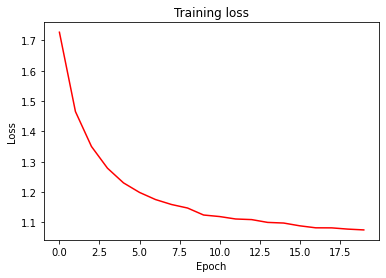

In [29]:
plot_loss(train_losses, 'Training')  

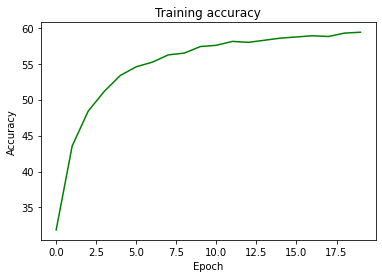

In [30]:
plot_acc(train_accs, 'Training')

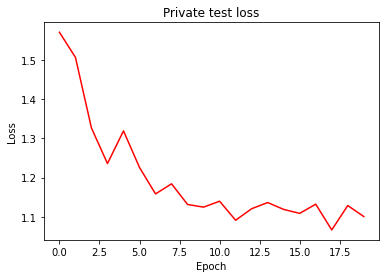

In [31]:
plot_loss(p_test_losses, 'Private test')

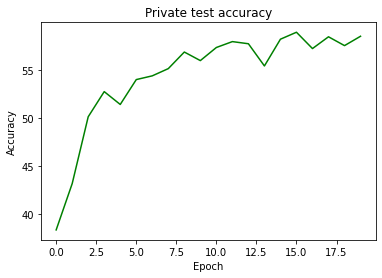

In [32]:
plot_acc(p_test_accs, 'Private test')

### 4. Evaluate the model

#### grad-cam.py

In [33]:
# see https://github.com/kazuto1011/grad-cam-pytorch
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.logits = self.logits.unsqueeze(0)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation

        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """
        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )
        
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)
        return gcam

#### check.py

In [34]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
shape = (48,48)
classes = ['Angry','Disgust','Fear','Happy','Sad','Surprised','Neutral']

In [35]:
def preprocess(image_path):
  transform_test = transforms.Compose([
    transforms.ToTensor()
  ])
  image = cv2.imread(image_path)
  faces = faceCascade.detectMultiScale(
    image,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(1, 1),
    flags=cv2.CASCADE_SCALE_IMAGE
  )

  if len(faces) == 0:
    print('no face found')
    face = cv2.resize(image, shape)
  else:
    (x, y, w, h) = faces[0]
    face = image[y:y + h, x:x + w]
    face = cv2.resize(face, shape)

  img = Image.fromarray(face).convert('L')
  inputs = transform_test(img)
  return inputs, face


def get_gradient_image(gradient):
  gradient = gradient.cpu().numpy().transpose(1, 2, 0)
  gradient -= gradient.min()
  gradient /= gradient.max()
  gradient *= 255.0
  return np.uint8(gradient)


def get_gradcam_image(gcam, raw_image, paper_cmap=False):
  gcam = gcam.cpu().numpy()
  cmap = cm.jet_r(gcam)[..., :3] * 255.0
  if paper_cmap:
    alpha = gcam[..., None]
    gcam = alpha * cmap + (1 - alpha) * raw_image
  else:
    gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
  return np.uint8(gcam)


def guided_backprop(images, model_name):

  for i, image in enumerate(images):
    target, raw_image = preprocess(image['path'])
    image['image'] = target
    image['raw_image'] = raw_image

  # net = model.Model(num_classes=len(classes))
  net = Model(num_classes=len(classes)).to(device)
  checkpoint = torch.load(os.path.join('trained', model_name), map_location=torch.device('cuda'))
  net.load_state_dict(checkpoint['net'])
  net.eval()
  summary(net, (1, shape[0], shape[1]))
  
  ########## New added ##########
  sep_layers = []
  for name, layer in net.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
      if 'sepConv' in name:
        sep_layers.append(name)
  ###############################

  for layer in sep_layers:
    result_images = []
    for index, image in enumerate(images):
      img = torch.stack([image['image']]).to(device)
      bp = BackPropagation(model=net)
      probs, ids = bp.forward(img)
      gcam = GradCAM(model=net)
      _ = gcam.forward(img)

      gbp = GuidedBackPropagation(model=net)
      _ = gbp.forward(img)
      
      # Guided Backpropagation
      actual_emotion = ids[:,0]
      gbp.backward(ids=actual_emotion.reshape(1,1))
      gradients = gbp.generate()
      
      # Grad-CAM
      gcam.backward(ids=actual_emotion.reshape(1,1))
      regions = gcam.generate(target_layer=layer)
      
      # Get Images
      label_image = np.zeros((shape[0],65, 3), np.uint8)
      cv2.putText(label_image, classes[actual_emotion.data], (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

      prob_image = np.zeros((shape[0],60,3), np.uint8)
      cv2.putText(prob_image, '%.1f%%' % (probs.data[:,0] * 100), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

      guided_bpg_image = get_gradient_image(gradients[0])
      guided_bpg_image = cv2.merge((guided_bpg_image, guided_bpg_image, guided_bpg_image))
      
      grad_cam_image = get_gradcam_image(gcam=regions[0, 0],raw_image=image['raw_image'])
      
      guided_gradcam_image = get_gradient_image(torch.mul(regions, gradients)[0])
      guided_gradcam_image = cv2.merge((guided_gradcam_image, guided_gradcam_image, guided_gradcam_image))
      
      img = cv2.hconcat([image['raw_image'],label_image,prob_image,guided_bpg_image,grad_cam_image,guided_gradcam_image])
      result_images.append(img)
      print(image['path'],classes[actual_emotion.data], probs.data[:,0] * 100)
    print('\n')
    result = cv2.resize(cv2.vconcat(result_images), None, fx=2,fy=2)
    cv2.imwrite('test/guided_gradcam('+layer+').jpg',result)
  

def main2():
  guided_backprop(
    images=[
      {'path': 'test2/angry.jpg'},
      {'path': 'test2/happy.jpg'},
      {'path': 'test2/sad.jpg'},
      {'path': 'test2/surprised.jpg'},
    ],
    model_name='private_model_20_59.t7'
  )

if __name__ == "__main__":
  main2()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
              ReLU-3            [-1, 8, 46, 46]               0
            Conv2d-4            [-1, 8, 44, 44]             584
       BatchNorm2d-5            [-1, 8, 44, 44]              16
              ReLU-6            [-1, 8, 44, 44]               0
            Conv2d-7           [-1, 16, 22, 22]             128
       BatchNorm2d-8           [-1, 16, 22, 22]              32
            Conv2d-9            [-1, 8, 44, 44]              72
           Conv2d-10           [-1, 16, 44, 44]             128
  SeparableConv2d-11           [-1, 16, 44, 44]               0
      BatchNorm2d-12           [-1, 16, 44, 44]              32
             ReLU-13           [-1, 16, 44, 44]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


test2/angry.jpg Sad tensor([36.1536], device='cuda:0')
test2/happy.jpg Happy tensor([98.5564], device='cuda:0')
test2/sad.jpg Neutral tensor([80.9271], device='cuda:0')
test2/surprised.jpg Surprised tensor([51.1070], device='cuda:0')


test2/angry.jpg Sad tensor([36.1536], device='cuda:0')
test2/happy.jpg Happy tensor([98.5564], device='cuda:0')
test2/sad.jpg Neutral tensor([80.9271], device='cuda:0')
test2/surprised.jpg Surprised tensor([51.1070], device='cuda:0')


test2/angry.jpg Sad tensor([36.1536], device='cuda:0')
test2/happy.jpg Happy tensor([98.5564], device='cuda:0')
test2/sad.jpg Neutral tensor([80.9271], device='cuda:0')
test2/surprised.jpg Surprised tensor([51.1070], device='cuda:0')


test2/angry.jpg Sad tensor([36.1536], device='cuda:0')
test2/happy.jpg Happy tensor([98.5564], device='cuda:0')
test2/sad.jpg Neutral tensor([80.9271], device='cuda:0')
test2/surprised.jpg Surprised tensor([51.1070], device='cuda:0')


test2/angry.jpg Sad tensor([36.1536], device='cuda:0')
t

### 4

There are total 4 residual blocks, each consists of two separable convolutional layers. Each separable convolutional layer consists of one depth-wise layer and one point-wise layer. Total of two depth-wise layers and two point-wise layers. 

Run check.py in 'test' folder. Output images generated using Grad-CAM for 16 separable convolutional layers are shown below.

For the 1st residual block (rb1), the first pair of sepConv layers (rb1.sepConv1.depthwise & rb1.sepConv1.pointwise) only highlights a few important regions in the explanation map. Notice that most of the important regions are small dots. However, in general, these dots are forming the outline of the face but somewhat vague and unprecise. The second pair of sepConv layers (rb1.sepConv2.depthwise & rb1.sepConv2.pointwise) give more meaningful information about the facial outline and details of emotion. As the explanation map shown, more important regions like eyes and mouth are highlighted. Moreover, from the guided Grad-CAM images, it is more clear to observe and recognize the emotion type.<br><br>

For the 2nd residual block (rb2), the first pair of sepConv layers (rb2.sepConv1.depthwise & rb2.sepConv1.pointwise) gives a worse representation of the current layer compared to rb1. From the explanation map, less facial features are highlighted except the sad face. The second pair of sepConv layers (rb2.sepConv2.depthwise & rb2.sepConv2.pointwise) also provide less important features in the explanation map.<br><br>

For the 3rd residual block (rb3), main facial features are now highlighted in both the first and the second pair of sepConv layers. Visually, we could see the second sepConv layer (sepConv2) explains the model well. As the images with a high confidence score are highlighted with more key features and those with a low confidence score are highlighted with less key features.<br><br>

Lastly, for the 4th residual block (rb4), the Grad-CAM explanation maps explain the model well in general. Compared to the previous residual block, the last 4 sepConv layers focus more on highlighting the main facial features like mouth, eyes and nose located in the center of each face image except for the third sad face. Relative high confidence scores are given to the angry, happy and surprised faces and low confidence score is given to the sad face. Thus, from these last four sepConv layers, Grad-CAM explain the model well.

Comments on model performance:<br>
For images in test folder, the model gives relatively high confidence scores for angry, happy and surprised faces and low confidence score for the sad face.

### 5: Evaluate model on test2

Below are output images generated using Grad-CAM on images in test2 folder.<br><br>
For the 1st residual block (rb1), the explantion map plots several dots around the main facial features like eyes, mouth and nose, in the first pair of sepConv layers. The second pair of sepConv layers improves this by plotting more dots around the main features. However, it is still hard to see the highlighted features of this block in the guided Grad-CAM.
<br><br>
For the 2nd residual block (rb2), the first pair of sepConv layers captures the main features of the happy face. Also, from the Grad-CAM for the happy face, important facial features are localized correctly which explains the model having a the highest confidence score for it. And for the surprised face, a second highest confidence score is achieved by the model. From the Grad-CAM, there are too many less important features. That explains why the model has a lower confidence score. For the other two faces, we can see only some less meaningful features are highlighted which explains also the low confidence scores. 
<br><br>
For the 3rd residual block (rb3), for both pairs of sepConv layers, main facial features are captured by Grad-CAM except for the angry face.
<br><br>
For the 4th residual block (rb4), in general, both pairs of sepConv layers are well explained by Grad-CAM since the highlighed features are focused in the middle part of each face. Thus, from the guided Grad-CAM, we can clearly observe the eyes, mouth, nose of each face.

Comments on model performance:<br>
For images in test2 folder, only the happy face and surprised face are correctly classified by the model. The other two, angry and sad faces are misclassified as fear and neutral respectively. In conclusion, the model performance on this test images are worse than that on images in test folder.

Reasoning for performance decrease in model predictions & activations:<br>
Notice that in both folders, the happy and surprised faces are given higher confidence scores. And the other two, angry and sad faces are given lower confidence scores or even misclassified as other emotion classes. This might due to the training data are imbalanced in number of true labels meaning more happy, surprised faces and less angry, sad faces are provided for the model to learn.

### 6. Class-Reweighting

In [ ]:
import collections

factory = DataSetFactory()
training_loader = DataLoader(factory.training, batch_size=128, shuffle=False, num_workers=1)

emotions = []
for i, (x_train, y_train) in enumerate(training_loader):
  emotions.extend(y_train.tolist())
emotion_dict = collections.Counter(emotions)
print(emotion_dict)

training size 28709 : private val size 3589 : public val size 3589
Counter({3: 7215, 6: 4965, 4: 4830, 2: 4097, 0: 3995, 5: 3171, 1: 436})


In [ ]:
e_dict = {}
for key,value in emotion_dict.items():
  e_dict[classes[key]] = value
print(e_dict)

{'Angry': 3995, 'Fear': 4097, 'Sad': 4830, 'Neutral': 4965, 'Happy': 7215, 'Surprised': 3171, 'Disgust': 436}


([<matplotlib.patches.Wedge at 0x7f07312be450>,
 [Text(0.9965496146813458, 0.465713286774665, 'Angry'),
  Text(0.2701507343310181, 1.0663107336702617, 'Fear'),
  Text(-0.7325243008999525, 0.8206144945045976, 'Sad'),
  Text(-1.0710830407004805, -0.2505616090382027, 'Neutral'),
  Text(-0.008967705520216612, -1.0999634449642872, 'Happy'),
  Text(0.9940896172176412, -0.47094143260078924, 'Surprised'),
  Text(1.0987482443604089, -0.05246232471897622, 'Disgust')],
 [Text(0.5435725170989159, 0.25402542914981724, '13.9%'),
  Text(0.14735494599873714, 0.5816240365474155, '14.3%'),
  Text(-0.3995587095817922, 0.4476079060934168, '16.8%'),
  Text(-0.5842271131093529, -0.13666996856629235, '17.3%'),
  Text(-0.00489147573829997, -0.5999800608896112, '25.1%'),
  Text(0.5422307003005316, -0.25687714505497594, '11.0%'),
  Text(0.5993172241965866, -0.028615813483077936, '1.5%')])

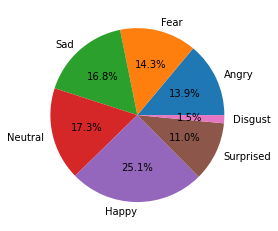

In [ ]:
import matplotlib.pyplot as plt
plt.pie(e_dict.values(),labels=e_dict.keys(), autopct='%1.1f%%')

As the pie chart shown, the frequency of 'happy' labeled faces takes around 25% which is the most frequent one. And the least frequent one is the 'disgust' labeled faces. Notice from previous sections, the model is tested on test and test2 folders. From the output, it shows the confidence score for 'happy' face is always larger than the others which agrees with class imbalance assumption that I made in the previous section. As the class is unbiased, we shall perform class-reweighting to overcome this issue.

In [ ]:
def main_weighted():
  # variables  -------------
  batch_size = 128
  lr = 0.01
  epochs = 20
  learning_rate_decay_start = 80
  learning_rate_decay_every = 5
  learning_rate_decay_rate = 0.9
  # Add variables
  train_losses = []
  train_accs = []

  p_test_losses = []
  p_test_accs = []
  # ------------------------

  classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  network = Model(num_classes=len(classes)).to(device)
  if not torch.cuda.is_available():
    summary(network, (1, shape[0], shape[1]))

  optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=5e-3)
  w = torch.tensor([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]).to(device)
  criterion = nn.CrossEntropyLoss(weight=w) # Add weights for class-reweighting
  factory = DataSetFactory()

  training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=1)
  validation_loader = {
    'private': DataLoader(factory.private, batch_size=batch_size, shuffle=True, num_workers=1),
    'public': DataLoader(factory.public, batch_size=batch_size, shuffle=True, num_workers=1)
  }

  min_validation_loss = {
    'private': 10000,
    'public': 10000,
  }

  for epoch in tqdm(range(epochs)):
    network.train()
    total = 0
    correct = 0
    total_train_loss = 0
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
      frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
      decay_factor = learning_rate_decay_rate ** frac
      current_lr = lr * decay_factor
      for group in optimizer.param_groups:
        group['lr'] = current_lr
    else:
      current_lr = lr

    print('learning_rate: %s' % str(current_lr))
    for i, (x_train, y_train) in enumerate(training_loader):
      optimizer.zero_grad()
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      y_predicted = network(x_train)
      loss = criterion(y_predicted, y_train)
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(y_predicted.data, 1)
      total_train_loss += loss.data
      total += y_train.size(0)
      correct += predicted.eq(y_train.data).sum()
    accuracy = 100. * float(correct) / total
    print('Epoch [%d/%d] Training Loss: %.4f, Accuracy: %.4f' % (
      epoch + 1, epochs, total_train_loss / (i + 1), accuracy))
    
    # Record train loss
    train_losses.append(total_train_loss / (i + 1))
    # Record train acc
    train_accs.append(accuracy)
    

    network.eval()
    with torch.no_grad():
      # Added 
      total_p = 0
      correct_p = 0
      total_validation_loss_p = 0
      p_count = 0
      accuracy_p = 0
      for name in ['private', 'public']:
        total = 0
        correct = 0
        total_validation_loss = 0
        
        for j, (x_val, y_val) in enumerate(validation_loader[name]):
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          y_val_predicted = network(x_val)
          val_loss = criterion(y_val_predicted, y_val)
          _, predicted = torch.max(y_val_predicted.data, 1)
          total_validation_loss += val_loss.data
          # Only record private
          if name == 'private':
            total_validation_loss_p += val_loss.data
            p_count += 1
            total_p += y_val.size(0)
            correct_p += predicted.eq(y_val.data).sum()

          total += y_val.size(0)
          correct += predicted.eq(y_val.data).sum()

        accuracy = 100. * float(correct) / total
        if name =='private':
          accuracy_p = 100. * float(correct_p) / total_p
        
        if total_validation_loss <= min_validation_loss[name]:
          if epoch >= 10:
            print('saving new model')
            state = {'net': network.state_dict()}
            # torch.save(state, '../trained/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
            torch.save(state, 'trained/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
          min_validation_loss[name] = total_validation_loss

        print('Epoch [%d/%d] %s validation Loss: %.4f, Accuracy: %.4f' % (
          epoch + 1, epochs, name, total_validation_loss / (j + 1), accuracy))
        
        # Record private test loss
        p_test_losses.append(total_validation_loss_p / p_count)
        p_test_accs.append(accuracy_p)

  return train_losses, train_accs, p_test_losses, p_test_accs

In [ ]:
train_losses_w, train_accs_w, p_test_losses_w, p_test_accs_w = main_weighted()
print('Time Taken- ', str(time.time()-start_time), ' seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

training size 28709 : private val size 3589 : public val size 3589
learning_rate: 0.01
Epoch [1/20] Training Loss: 1.7218, Accuracy: 31.9168
Epoch [1/20] private validation Loss: 1.5553, Accuracy: 39.2867


  5%|▌         | 1/20 [00:11<03:39, 11.53s/it]

Epoch [1/20] public validation Loss: 1.5434, Accuracy: 39.8161
learning_rate: 0.01
Epoch [2/20] Training Loss: 1.4601, Accuracy: 43.3000
Epoch [2/20] private validation Loss: 1.3660, Accuracy: 48.4536


 10%|█         | 2/20 [00:22<03:26, 11.49s/it]

Epoch [2/20] public validation Loss: 1.3690, Accuracy: 47.1719
learning_rate: 0.01
Epoch [3/20] Training Loss: 1.3298, Accuracy: 48.9707
Epoch [3/20] private validation Loss: 1.3143, Accuracy: 49.6796


 15%|█▌        | 3/20 [00:34<03:14, 11.47s/it]

Epoch [3/20] public validation Loss: 1.2911, Accuracy: 50.2647
learning_rate: 0.01
Epoch [4/20] Training Loss: 1.2539, Accuracy: 51.9907
Epoch [4/20] private validation Loss: 1.2828, Accuracy: 51.6857


 20%|██        | 4/20 [00:45<03:03, 11.45s/it]

Epoch [4/20] public validation Loss: 1.2745, Accuracy: 51.6857
learning_rate: 0.01
Epoch [5/20] Training Loss: 1.1987, Accuracy: 54.5195
Epoch [5/20] private validation Loss: 1.2150, Accuracy: 53.1903


 25%|██▌       | 5/20 [00:57<02:51, 11.43s/it]

Epoch [5/20] public validation Loss: 1.2015, Accuracy: 53.8312
learning_rate: 0.01
Epoch [6/20] Training Loss: 1.1622, Accuracy: 55.9372
Epoch [6/20] private validation Loss: 1.1840, Accuracy: 54.2770


 30%|███       | 6/20 [01:08<02:39, 11.42s/it]

Epoch [6/20] public validation Loss: 1.2243, Accuracy: 53.9426
learning_rate: 0.01
Epoch [7/20] Training Loss: 1.1403, Accuracy: 57.1633
Epoch [7/20] private validation Loss: 1.1384, Accuracy: 54.5834


 35%|███▌      | 7/20 [01:19<02:28, 11.41s/it]

Epoch [7/20] public validation Loss: 1.1788, Accuracy: 55.0014
learning_rate: 0.01
Epoch [8/20] Training Loss: 1.1237, Accuracy: 57.7728
Epoch [8/20] private validation Loss: 1.1673, Accuracy: 55.3915


 40%|████      | 8/20 [01:31<02:16, 11.40s/it]

Epoch [8/20] public validation Loss: 1.1960, Accuracy: 54.0262
learning_rate: 0.01
Epoch [9/20] Training Loss: 1.1107, Accuracy: 58.1386
Epoch [9/20] private validation Loss: 1.1639, Accuracy: 56.3945


 45%|████▌     | 9/20 [01:42<02:05, 11.39s/it]

Epoch [9/20] public validation Loss: 1.1880, Accuracy: 55.7816
learning_rate: 0.01
Epoch [10/20] Training Loss: 1.0984, Accuracy: 58.4904
Epoch [10/20] private validation Loss: 1.1642, Accuracy: 54.7506


 50%|█████     | 10/20 [01:54<01:53, 11.39s/it]

Epoch [10/20] public validation Loss: 1.2151, Accuracy: 53.9147
learning_rate: 0.01
Epoch [11/20] Training Loss: 1.0917, Accuracy: 58.8039
saving new model
Epoch [11/20] private validation Loss: 1.1364, Accuracy: 56.5339
saving new model


 55%|█████▌    | 11/20 [02:06<01:44, 11.65s/it]

Epoch [11/20] public validation Loss: 1.1632, Accuracy: 54.3884
learning_rate: 0.01
Epoch [12/20] Training Loss: 1.0861, Accuracy: 59.2427
saving new model
Epoch [12/20] private validation Loss: 1.1151, Accuracy: 56.6453


 60%|██████    | 12/20 [02:18<01:33, 11.72s/it]

Epoch [12/20] public validation Loss: 1.1701, Accuracy: 55.1407
learning_rate: 0.01
Epoch [13/20] Training Loss: 1.0740, Accuracy: 58.9397
saving new model
Epoch [13/20] private validation Loss: 1.0939, Accuracy: 58.2335
saving new model


 65%|██████▌   | 13/20 [02:30<01:23, 11.97s/it]

Epoch [13/20] public validation Loss: 1.1535, Accuracy: 55.8930
learning_rate: 0.01
Epoch [14/20] Training Loss: 1.0685, Accuracy: 59.4901
saving new model
Epoch [14/20] private validation Loss: 1.0884, Accuracy: 57.7877


 70%|███████   | 14/20 [02:42<01:11, 11.94s/it]

saving new model
Epoch [14/20] public validation Loss: 1.1273, Accuracy: 57.8434
learning_rate: 0.01
Epoch [15/20] Training Loss: 1.0599, Accuracy: 60.0265
Epoch [15/20] private validation Loss: 1.1199, Accuracy: 58.6236


 75%|███████▌  | 15/20 [02:53<00:58, 11.78s/it]

saving new model
Epoch [15/20] public validation Loss: 1.1024, Accuracy: 57.5648
learning_rate: 0.01
Epoch [16/20] Training Loss: 1.0571, Accuracy: 60.2146
Epoch [16/20] private validation Loss: 1.0967, Accuracy: 58.7907


 80%|████████  | 16/20 [03:05<00:46, 11.66s/it]

Epoch [16/20] public validation Loss: 1.1179, Accuracy: 58.4564
learning_rate: 0.01
Epoch [17/20] Training Loss: 1.0442, Accuracy: 60.5803
Epoch [17/20] private validation Loss: 1.0895, Accuracy: 56.9797


 85%|████████▌ | 17/20 [03:16<00:34, 11.58s/it]

Epoch [17/20] public validation Loss: 1.1231, Accuracy: 57.8155
learning_rate: 0.01
Epoch [18/20] Training Loss: 1.0440, Accuracy: 60.6360
Epoch [18/20] private validation Loss: 1.1078, Accuracy: 57.8434


 90%|█████████ | 18/20 [03:28<00:23, 11.51s/it]

Epoch [18/20] public validation Loss: 1.1630, Accuracy: 56.3110
learning_rate: 0.01
Epoch [19/20] Training Loss: 1.0411, Accuracy: 60.5072
saving new model
Epoch [19/20] private validation Loss: 1.0756, Accuracy: 58.6793


 95%|█████████▌| 19/20 [03:39<00:11, 11.61s/it]

Epoch [19/20] public validation Loss: 1.1357, Accuracy: 57.1468
learning_rate: 0.01
Epoch [20/20] Training Loss: 1.0359, Accuracy: 60.7858
saving new model
Epoch [20/20] private validation Loss: 1.0627, Accuracy: 59.6545
saving new model


100%|██████████| 20/20 [03:51<00:00, 11.60s/it]

Epoch [20/20] public validation Loss: 1.0958, Accuracy: 58.3449
Time Taken-  1963.797435283661  seconds


In [ ]:
print('Epoch:',20)
print('Train loss:',float(train_losses_w[-1]))
print('Train accuracy:',float(train_accs_w[-1]))
print('Private test loss:',float(p_test_losses_w[-1]))
print('Private test accuracy:',float(p_test_accs_w[-1]))

Epoch: 20
Train loss: 1.035901427268982
Train accuracy: 60.78581629454178
Private test loss: 1.0627374649047852
Private test accuracy: 59.654499860685426


In [ ]:
def main3():
  guided_backprop(
    images=[
      {'path': 'test/angry.jpg'},
      {'path': 'test/happy.jpg'},
      {'path': 'test/sad.jpg'},
      {'path': 'test/surprised.jpg'},
    ],
    model_name='private_model_20_59.t7'
  )

if __name__ == "__main__":
  main3()

Train the model with class-reweighted training set with each class having 1/7 weight ratio of the total number of training data. Notice that class-reweighting is done when computing the cross entropy loss to overcome the problem of training on unbalanced data set.<br><br>
Training the class-reweighted model with 20 epoches, the training accuracy increases from 59.6% to 60.7% and the private training accuracy increases from 58.7% to 59.6%. Both the training loss and test loss decrease.<br><br> 
More specifically, below is the comparison of original output and class-reweighted output. For the test folder, notice that the confidence scores for each image are increased and the model classified each input correctly. For the test2 folder, even though the model still makes two misclassifications. The confidence score for the happy face has increased as well as the other faces. This indicates the improvement of model performance.

### 7.

*  Q: How does the selected method improve the model?
*  A: Class-reweighting method balances the frequency of each class in the training set. It assigns fixed ratios to each class in order to lower down the proportion of frequent occuring classes or increase the proportion of less frequent occuring classes. This would make the training set unbiased. Ideally, meaning the model performance will be improved by learning features from a complete and unbiased data set that contains a balanced set of different classes.

*  Q: Explanation of approach & limitations:
*  A: To overcome the issue of missing learning important features from the traingin set by undersampling or introducing duplicate samples by oversampling. I simply add weights to the cross entropy loss function when computing the loss. Specifically, assign different weights to the computed loss value for each sample based on the class it belongs to. That is low weight should be assigned to samples of majority class and high weight should be assigned to samples of minority class. Intuitively, this makes the loss function to penalize the model less on learning samples from the majority class and more on learning samples from the minority class. That effectively trains the model to learn comprehensively from both classes which would reduce the effects of training on biased data set.<br>
There are some limitions. First, there are many different weighting schemes. Sometimes, one scheme is better than the others. Thus, to effectively solve the problem of class imbalance, model should be trained using different weighting schemes and then compare the performance after all trainings are done. This could be problematic when the training set is large or training on complex structured models like deep neural networks with multiple layers. That is time consuming and unpractical to do. Second, when the classes are all large, class-reweighting might not be effective. Since that will cause the weights to be extremely small, and causing the computed loss to be extremely small. Small loss might lead to the problem of model underfitting. 

